# Desarrollo de sistema de prediccion de calidad del aire

## Cargar dataset

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime
from prettytable import PrettyTable
import missingno as msno



from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [177]:
df1=pd.read_csv('../datas/datos_180101_240101.txt', sep=',',encoding='latin-1',skiprows=36, skipfooter=9, engine='python', header=None)
df2=pd.read_csv('../datas/datos_180101_240101_mp2.5.txt', sep=',',encoding='latin-1',skiprows=36, skipfooter=9, engine='python', header=None)
df3=pd.read_csv('../datas/datos_180101_240101_mp10.txt', sep=',',encoding='latin-1',skiprows=36, skipfooter=9, engine='python', header=None)
df4=pd.read_csv('../datas/Temperaturas.csv')

## Visualizacion de dataframes

In [178]:
df1

,0,1,2,3,4,5
0,180101,0,,,,NaN
1,180102,0,,,,NaN
2,180103,0,,,,NaN
3,180104,0,,,,NaN
4,180105,0,,,,NaN
...,...,...,...,...,...,...
2186,231227,0,1,,,NaN
2187,231228,0,1,,,NaN
2188,231229,0,1,,,NaN
2189,231230,0,1,,,NaN


In [179]:
df2

,0,1,2,3,4,5
0,180101,0,6,,,NaN
1,180102,0,4,,,NaN
2,180103,0,6,,,NaN
3,180104,0,6,,,NaN
4,180105,0,7,,,NaN
...,...,...,...,...,...,...
2186,231227,0,6,,,NaN
2187,231228,0,7,,,NaN
2188,231229,0,7,,,NaN
2189,231230,0,4,,,NaN


In [180]:
df3

,0,1,2,3,4,5
0,180101,0,25,,,NaN
1,180102,0,25,,,NaN
2,180103,0,26,,,NaN
3,180104,0,23,,,NaN
4,180105,0,24,,,NaN
...,...,...,...,...,...,...
2186,231227,0,24,,,NaN
2187,231228,0,24,,,NaN
2188,231229,0,23,,,NaN
2189,231230,0,20,,,NaN


In [181]:
df4

,Dia - Mes,Temperatura media,Fecha Momento minima,Temperatura minima,Fecha Momento maxima,Temperatura maxima
0,180101,19.7,130101,14.9,070101,27.7
1,180102,19.6,030102,14.9,070102,25.0
2,180103,19.8,970103,15.0,980103,25.1
3,180104,19.7,930104,15.0,980104,25.5
4,180105,19.9,030105,14.8,170105,26.8
...,...,...,...,...,...,...
2191,231227,19.3,121227,13.3,971227,25.6
2192,231228,19.3,031228,14.2,971228,25.9
2193,231229,19.4,121229,14.1,971229,25.5
2194,231230,19.6,141230,14.3,961230,25.2


## Limpieza y Analisis exploratorio de datos

### Renombrar columnas

In [182]:
df1.columns=['date','hora','Reg_Val','Preliminar','Reg_no_Val', 'col_ext']
df2.columns=['date','hora','Reg_Val','Preliminar','Reg_no_Val', 'col_ext']
df3.columns=['date','hora','Reg_Val','Preliminar','Reg_no_Val', 'col_ext']
df4=df4.rename(columns={"Dia - Mes":'date'})

### Formatear fecha

In [183]:
df1['date'] = pd.to_datetime(df1['date'], format='%y%m%d').dt.strftime('%Y/%m/%d')
df1['date'] = df1['date'].apply(lambda x: datetime.strptime(str(x), '%Y/%m/%d') if not pd.isna(x) else None)
df2['date'] = pd.to_datetime(df2['date'], format='%y%m%d').dt.strftime('%Y/%m/%d')
df2['date'] = df2['date'].apply(lambda x: datetime.strptime(str(x), '%Y/%m/%d') if not pd.isna(x) else None)
df3['date'] = pd.to_datetime(df3['date'], format='%y%m%d').dt.strftime('%Y/%m/%d')
df3['date'] = df3['date'].apply(lambda x: datetime.strptime(str(x), '%Y/%m/%d') if not pd.isna(x) else None)
df4['date'] = df4['date'].astype(str)
df4['date'] = pd.to_datetime(df4['date'], format='%y%m%d', errors='coerce')

### General

In [184]:
df1=df1[['date','Reg_Val','Preliminar']]
df1['Reg_Val'] = pd.to_numeric(df1['Reg_Val'],errors='coerce')
df1['Preliminar'] = pd.to_numeric(df1['Preliminar'],errors='coerce')
df1.describe()

C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\4133598156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Reg_Val'] = pd.to_numeric(df1['Reg_Val'],errors='coerce')
C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\4133598156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Preliminar'] = pd.to_numeric(df1['Preliminar'],errors='coerce')


,date,Reg_Val,Preliminar
count,2191,1568.000000,421.000000
mean,2020-12-31 00:00:00,1.011888,1.010689
min,2018-01-01 00:00:00,1.000000,1.000000
25%,2019-07-02 12:00:00,1.000000,1.000000
50%,2020-12-31 00:00:00,1.000000,1.000000
75%,2022-07-01 12:00:00,1.000000,1.000000
max,2023-12-31 00:00:00,2.760000,1.300000
std,NaN,0.060713,0.049186


In [185]:
df2=df2[['date','Reg_Val','Preliminar']]
df2['Reg_Val'] = pd.to_numeric(df2['Reg_Val'], errors='coerce')
df2['Preliminar'] = pd.to_numeric(df2['Preliminar'], errors='coerce')
df2.describe()

C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\3834713635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Reg_Val'] = pd.to_numeric(df2['Reg_Val'], errors='coerce')
C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\3834713635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Preliminar'] = pd.to_numeric(df2['Preliminar'], errors='coerce')


,date,Reg_Val,Preliminar
count,2191,2122.000000,0.0
mean,2020-12-31 00:00:00,10.680019,NaN
min,2018-01-01 00:00:00,2.000000,NaN
25%,2019-07-02 12:00:00,7.000000,NaN
50%,2020-12-31 00:00:00,10.000000,NaN
75%,2022-07-01 12:00:00,13.000000,NaN
max,2023-12-31 00:00:00,27.000000,NaN
std,NaN,4.310100,NaN


In [186]:
df3=df3[['date','Reg_Val','Preliminar']]
df3['Reg_Val'] = pd.to_numeric(df3['Reg_Val'], errors='coerce')
df3['Preliminar'] = pd.to_numeric(df3['Preliminar'], errors='coerce')
df3.describe()

C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\2939612453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Reg_Val'] = pd.to_numeric(df3['Reg_Val'], errors='coerce')
C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\2939612453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Preliminar'] = pd.to_numeric(df3['Preliminar'], errors='coerce')


,date,Reg_Val,Preliminar
count,2191,2138.000000,0.0
mean,2020-12-31 00:00:00,33.074369,NaN
min,2018-01-01 00:00:00,7.000000,NaN
25%,2019-07-02 12:00:00,26.000000,NaN
50%,2020-12-31 00:00:00,32.000000,NaN
75%,2022-07-01 12:00:00,39.000000,NaN
max,2023-12-31 00:00:00,108.000000,NaN
std,NaN,10.136069,NaN


In [187]:
df4=df4[["date","Temperatura media"]]
df4.describe()

,date,Temperatura media
count,2191,2196.000000
mean,2020-12-31 00:00:00,16.709973
min,2018-01-01 00:00:00,13.400000
25%,2019-07-02 12:00:00,14.500000
50%,2020-12-31 00:00:00,16.300000
75%,2022-07-01 12:00:00,18.900000
max,2023-12-31 00:00:00,20.700000
std,NaN,2.288252


C:\Users\capv2\anaconda3\envs\Taller_Final\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
C:\Users\capv2\anaconda3\envs\Taller_Final\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
C:\Users\capv2\anaconda3\envs\Taller_Final\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
C:\Users\capv2\anaconda3\envs\Taller_Final\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


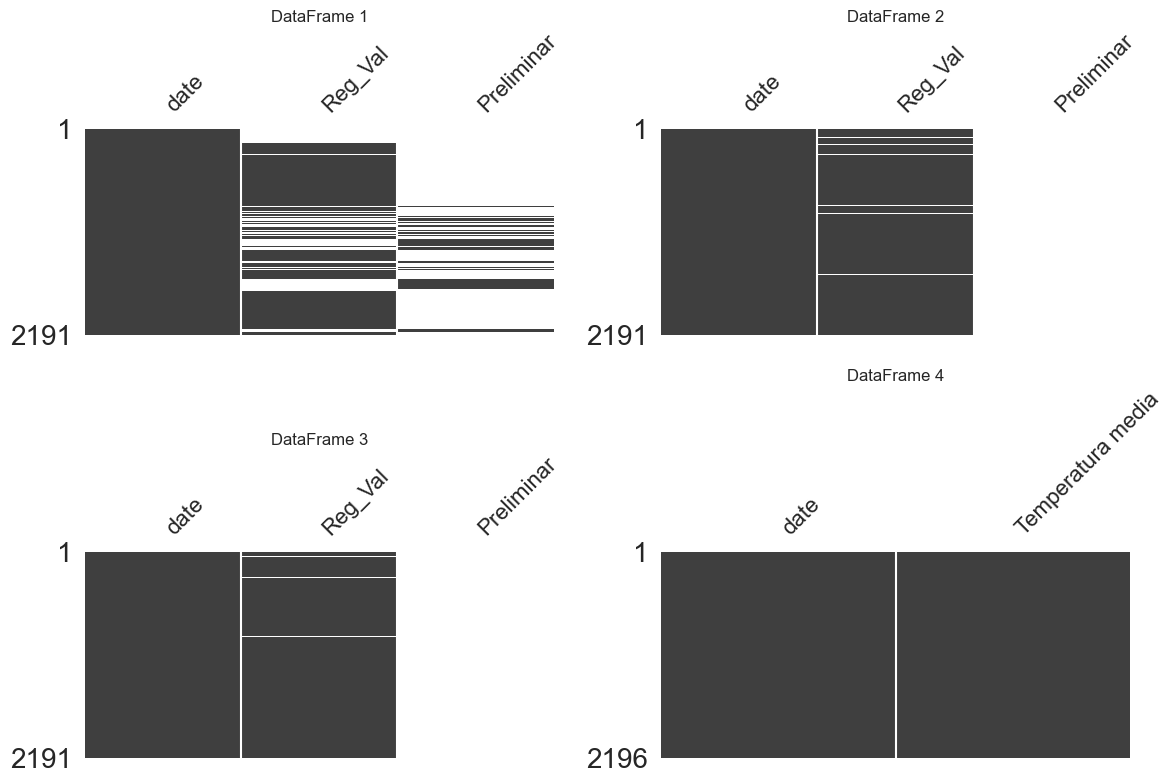

In [188]:
# Lista de los DataFrames
dataframes = [df1, df2, df3, df4]
# Crear una figura y una matriz de subgráficas de 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# Aplanar la matriz de ejes para iterar fácilmente
axes = axes.flatten()
# Graficar cada DataFrame en su subgráfica correspondiente
for i, df in enumerate(dataframes):
    msno.matrix(df, ax=axes[i])
    axes[i].set_title(f'DataFrame {i+1}')
# Ajustar el espacio entre las subgráficas
plt.tight_layout()
# Mostrar la figura
plt.show()

In [189]:
# Calculamos los valores nulos
null_counts_df1 = df1.isnull().sum()
null_counts_df2 = df2.isnull().sum()
null_counts_df3 = df3.isnull().sum()
null_counts_df4 = df4.isnull().sum()

# Crear una tabla con PrettyTable
table = PrettyTable()

# Añadir encabezados de columna
table.field_names = ["Column", "DF1 Nulls", "DF2 Nulls", "DF3 Nulls", "DF4 Nulls"]

# Añadir filas a la tabla
columns = set(null_counts_df1.index) | set(null_counts_df2.index) | set(null_counts_df3.index) | set(null_counts_df4.index)
for col in columns:
    table.add_row([
        col,
        null_counts_df1.get(col, 0),
        null_counts_df2.get(col, 0),
        null_counts_df3.get(col, 0),
        null_counts_df4.get(col, 0)
    ])

# Imprimir la tabla
print(table)

+-------------------+-----------+-----------+-----------+-----------+
|       Column      | DF1 Nulls | DF2 Nulls | DF3 Nulls | DF4 Nulls |
+-------------------+-----------+-----------+-----------+-----------+
|     Preliminar    |    1770   |    2191   |    2191   |     0     |
|      Reg_Val      |    623    |     69    |     53    |     0     |
| Temperatura media |     0     |     0     |     0     |     0     |
|        date       |     0     |     0     |     0     |     5     |
+-------------------+-----------+-----------+-----------+-----------+


#### Eliminan datos erronos

In [190]:
df4=df4.dropna()

In [191]:
df4=df4.reset_index()

In [192]:
df4

,index,date,Temperatura media
0,0,2018-01-01,19.7
1,1,2018-01-02,19.6
2,2,2018-01-03,19.8
3,3,2018-01-04,19.7
4,4,2018-01-05,19.9
...,...,...,...
2186,2191,2023-12-27,19.3
2187,2192,2023-12-28,19.3
2188,2193,2023-12-29,19.4
2189,2194,2023-12-30,19.6


In [193]:
duplicated_dates = df3[df3.duplicated(subset='date', keep=False)]
duplicated_dates

,date,Reg_Val,Preliminar


### Datos faltantes compensados con preliminares

In [194]:
# Función para rellenar valores nulos de la segunda columna con valores de la tercera
def fill_second_column_with_third(df, condition):
    # Obtener los nombres de las columnas
    second_col = df.columns[1]
    third_col = df.columns[2]
    
    # Crear una máscara para los valores nulos en la segunda columna
    null_mask = df[second_col].isnull()
    
    # Aplicar la condición a la tercera columna
    condition_mask = condition(df[third_col])
    
    # Combinar las máscaras
    fill_mask = null_mask & condition_mask
    
    # Rellenar los valores nulos de la segunda columna que cumplen la condición
    df.loc[fill_mask, second_col] = df.loc[fill_mask, third_col]
    
    return df



In [195]:
# Definir la condición (valores no nulos en la tercera columna)
condition = lambda x: ~pd.isna(x)
# Aplicar la función al DataFrame
df1 = fill_second_column_with_third(df1, condition)
df2 = fill_second_column_with_third(df2, condition)
df3 = fill_second_column_with_third(df3, condition)

In [196]:
df1.describe()

,date,Reg_Val,Preliminar
count,2191,1989.000000,421.000000
mean,2020-12-31 00:00:00,1.011634,1.010689
min,2018-01-01 00:00:00,1.000000,1.000000
25%,2019-07-02 12:00:00,1.000000,1.000000
50%,2020-12-31 00:00:00,1.000000,1.000000
75%,2022-07-01 12:00:00,1.000000,1.000000
max,2023-12-31 00:00:00,2.760000,1.300000
std,NaN,0.058453,0.049186


In [197]:
df2.describe()

,date,Reg_Val,Preliminar
count,2191,2122.000000,0.0
mean,2020-12-31 00:00:00,10.680019,NaN
min,2018-01-01 00:00:00,2.000000,NaN
25%,2019-07-02 12:00:00,7.000000,NaN
50%,2020-12-31 00:00:00,10.000000,NaN
75%,2022-07-01 12:00:00,13.000000,NaN
max,2023-12-31 00:00:00,27.000000,NaN
std,NaN,4.310100,NaN


In [198]:
df3.describe()

,date,Reg_Val,Preliminar
count,2191,2138.000000,0.0
mean,2020-12-31 00:00:00,33.074369,NaN
min,2018-01-01 00:00:00,7.000000,NaN
25%,2019-07-02 12:00:00,26.000000,NaN
50%,2020-12-31 00:00:00,32.000000,NaN
75%,2022-07-01 12:00:00,39.000000,NaN
max,2023-12-31 00:00:00,108.000000,NaN
std,NaN,10.136069,NaN


### Creacion de dataset

In [199]:
len(df4["Temperatura media"])

2191

In [200]:
df4.tail()

,index,date,Temperatura media
2186,2191,2023-12-27,19.3
2187,2192,2023-12-28,19.3
2188,2193,2023-12-29,19.4
2189,2194,2023-12-30,19.6
2190,2195,2023-12-31,19.6


In [201]:
df=pd.concat([df1["date"], df1["Reg_Val"], df2["Reg_Val"],df3["Reg_Val"], df4["Temperatura media"]], axis=1)

In [202]:
len(df)

2191

In [203]:
df.tail()

,date,Reg_Val,Reg_Val,Reg_Val,Temperatura media
2186,2023-12-27,1.0,6.0,24.0,19.3
2187,2023-12-28,1.0,7.0,24.0,19.3
2188,2023-12-29,1.0,7.0,23.0,19.4
2189,2023-12-30,1.0,4.0,20.0,19.6
2190,2023-12-31,1.0,11.0,23.0,19.6


In [204]:
df.head()

,date,Reg_Val,Reg_Val,Reg_Val,Temperatura media
0,2018-01-01,NaN,6.0,25.0,19.7
1,2018-01-02,NaN,4.0,25.0,19.6
2,2018-01-03,NaN,6.0,26.0,19.8
3,2018-01-04,NaN,6.0,23.0,19.7
4,2018-01-05,NaN,7.0,24.0,19.9


In [205]:
df.columns=['date','SO4','MP10','MP2.5', 'Tem_amb_med']
df

,date,SO4,MP10,MP2.5,Tem_amb_med
0,2018-01-01,NaN,6.0,25.0,19.7
1,2018-01-02,NaN,4.0,25.0,19.6
2,2018-01-03,NaN,6.0,26.0,19.8
3,2018-01-04,NaN,6.0,23.0,19.7
4,2018-01-05,NaN,7.0,24.0,19.9
...,...,...,...,...,...
2186,2023-12-27,1.0,6.0,24.0,19.3
2187,2023-12-28,1.0,7.0,24.0,19.3
2188,2023-12-29,1.0,7.0,23.0,19.4
2189,2023-12-30,1.0,4.0,20.0,19.6


In [206]:
duplicated_dates = df[df.duplicated(subset='date', keep=False)]
duplicated_dates

,date,SO4,MP10,MP2.5,Tem_amb_med


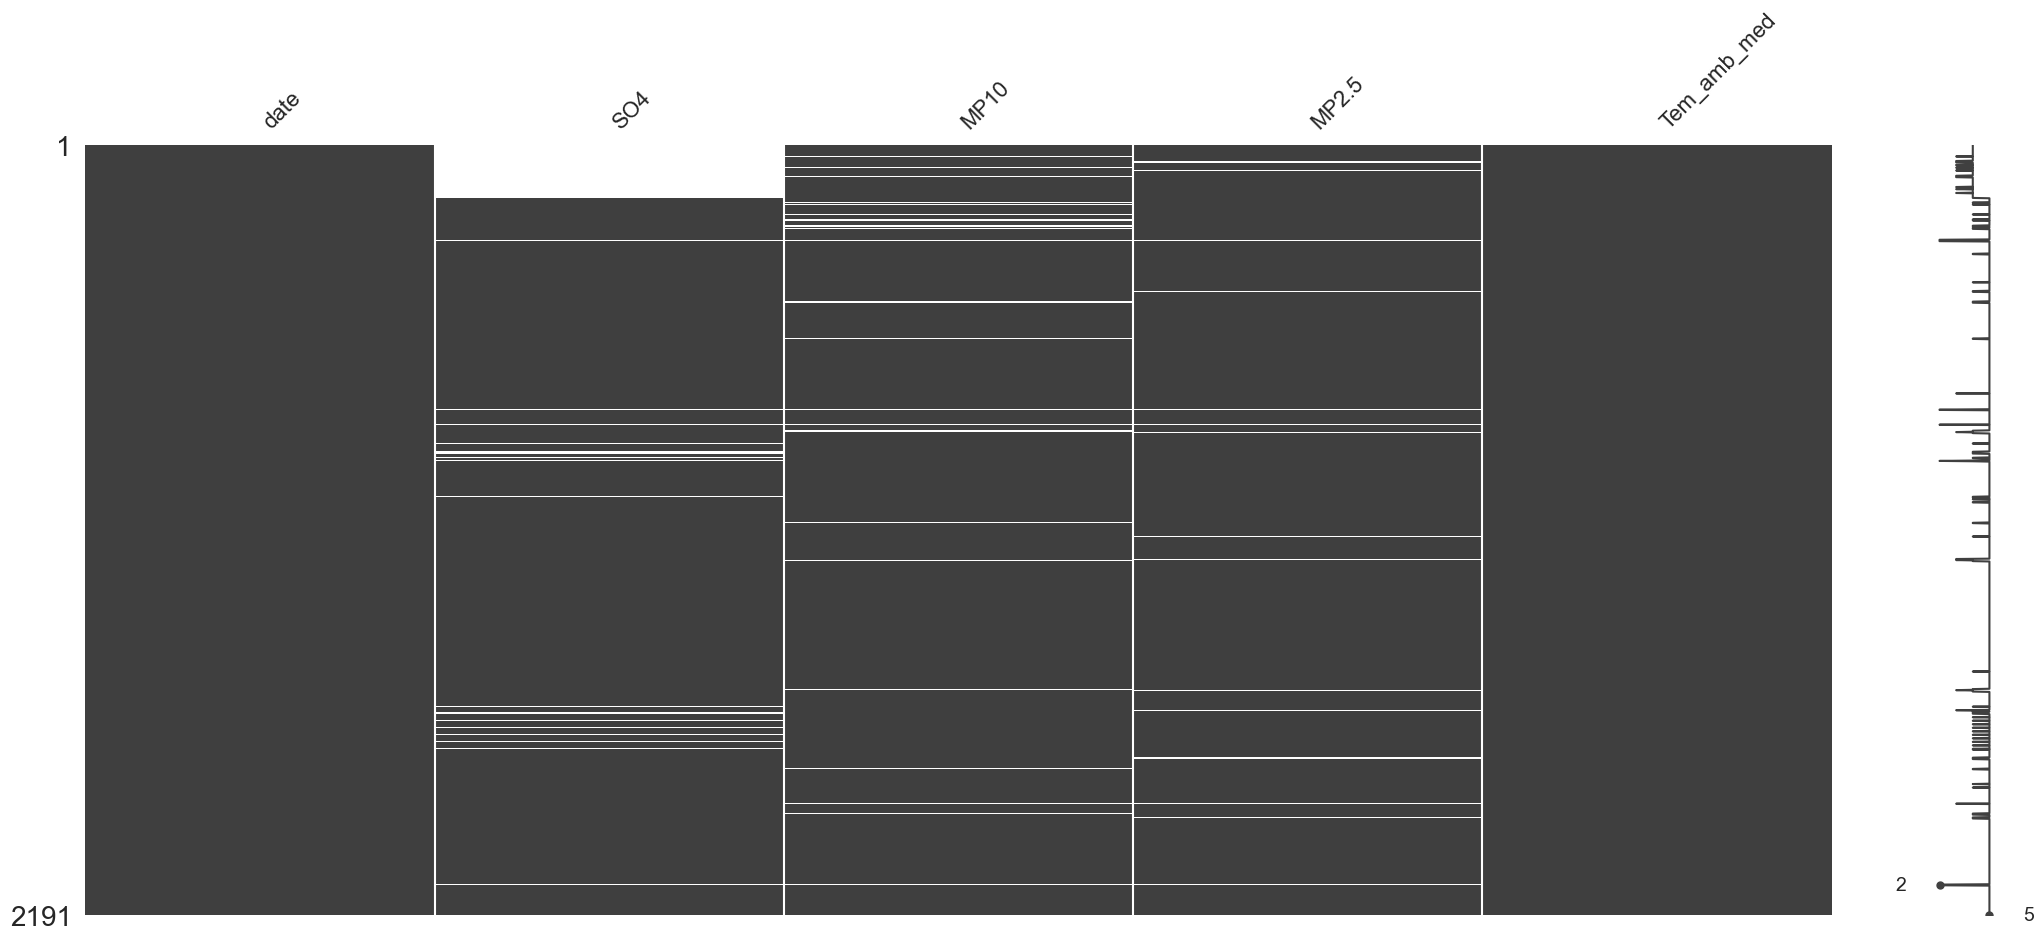

<Figure size 1500x900 with 0 Axes>

In [207]:
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

In [208]:
df.iloc[2190]

date           2023-12-31 00:00:00
SO4                            1.0
MP10                          11.0
MP2.5                         23.0
Tem_amb_med                   19.6
Name: 2190, dtype: object

### Visualizaciones

In [209]:
X=df[['date','SO4']]
X2=df[['date','MP2.5']]
X3=df[['date','MP10']]
X4=df[['date','Tem_amb_med']]

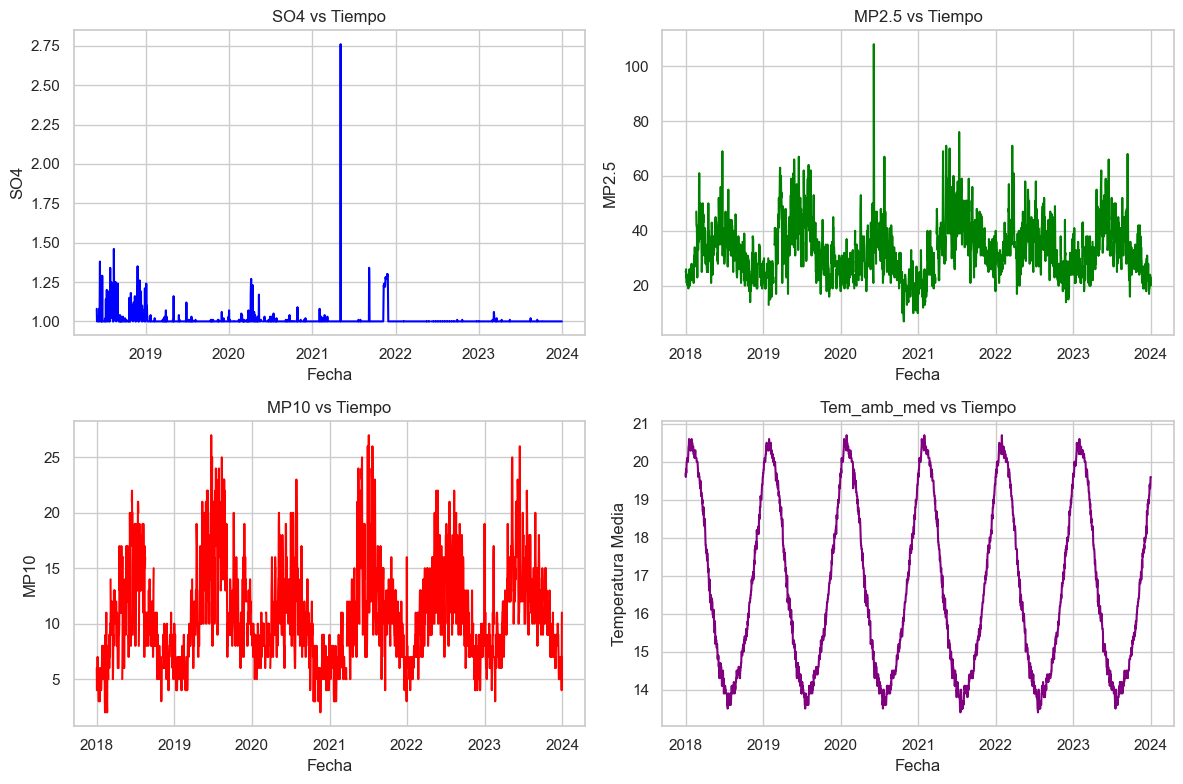

In [210]:
# Crear las subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gráfica para SO4
axs[0, 0].plot(df['date'], df['SO4'], color='blue')
axs[0, 0].set_title('SO4 vs Tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('SO4')

# Gráfica para MP2.5
axs[0, 1].plot(df['date'], df['MP2.5'], color='green')
axs[0, 1].set_title('MP2.5 vs Tiempo')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].set_ylabel('MP2.5')

# Gráfica para MP10
axs[1, 0].plot(df['date'], df['MP10'], color='red')
axs[1, 0].set_title('MP10 vs Tiempo')
axs[1, 0].set_xlabel('Fecha')
axs[1, 0].set_ylabel('MP10')

# Gráfica para Tem_amb_med
axs[1, 1].plot(df['date'], df['Tem_amb_med'], color='purple')
axs[1, 1].set_title('Tem_amb_med vs Tiempo')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].set_ylabel('Temperatura Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

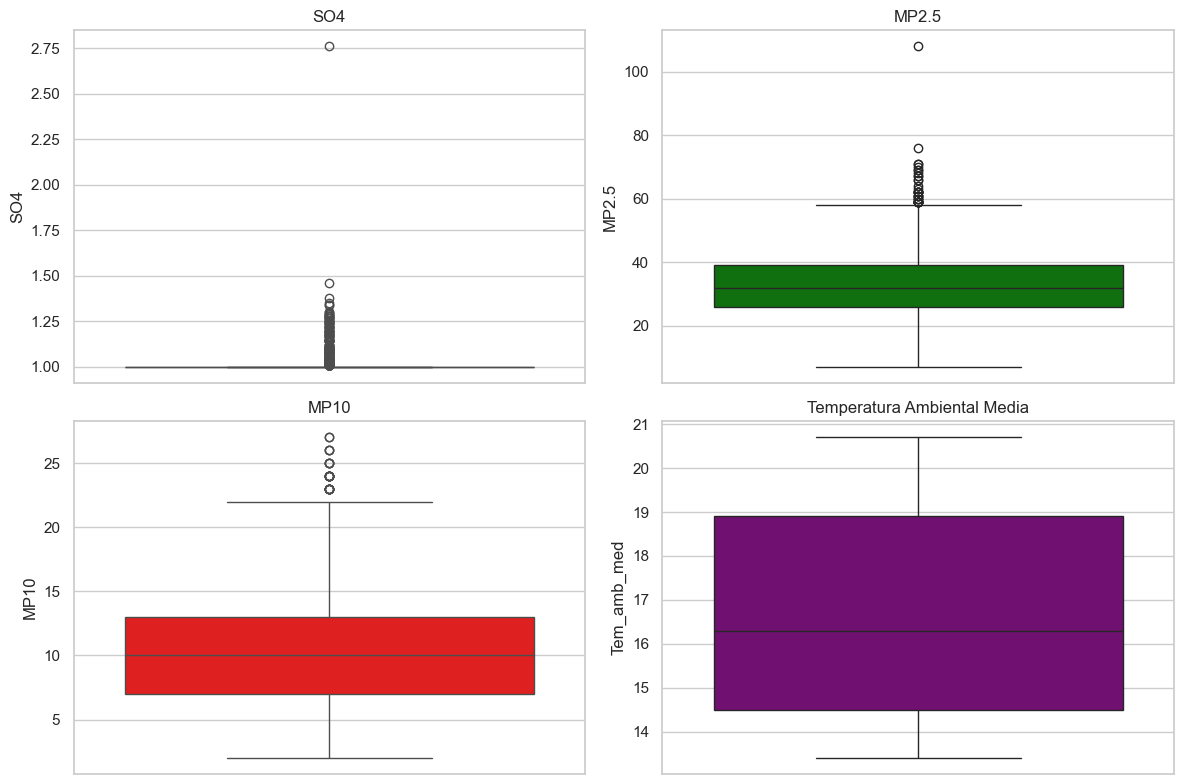

In [211]:
# Estilo de seaborn
sns.set(style="whitegrid")

# Crear las subgráficas 2x2 para los boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot para SO4
sns.boxplot(y=df['SO4'], ax=axs[0, 0], color='blue')
axs[0, 0].set_title('SO4')

# Boxplot para MP2.5
sns.boxplot(y=df['MP2.5'], ax=axs[0, 1], color='green')
axs[0, 1].set_title('MP2.5')

# Boxplot para MP10
sns.boxplot(y=df['MP10'], ax=axs[1, 0], color='red')
axs[1, 0].set_title('MP10')

# Boxplot para Tem_amb_med
sns.boxplot(y=df['Tem_amb_med'], ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Temperatura Ambiental Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

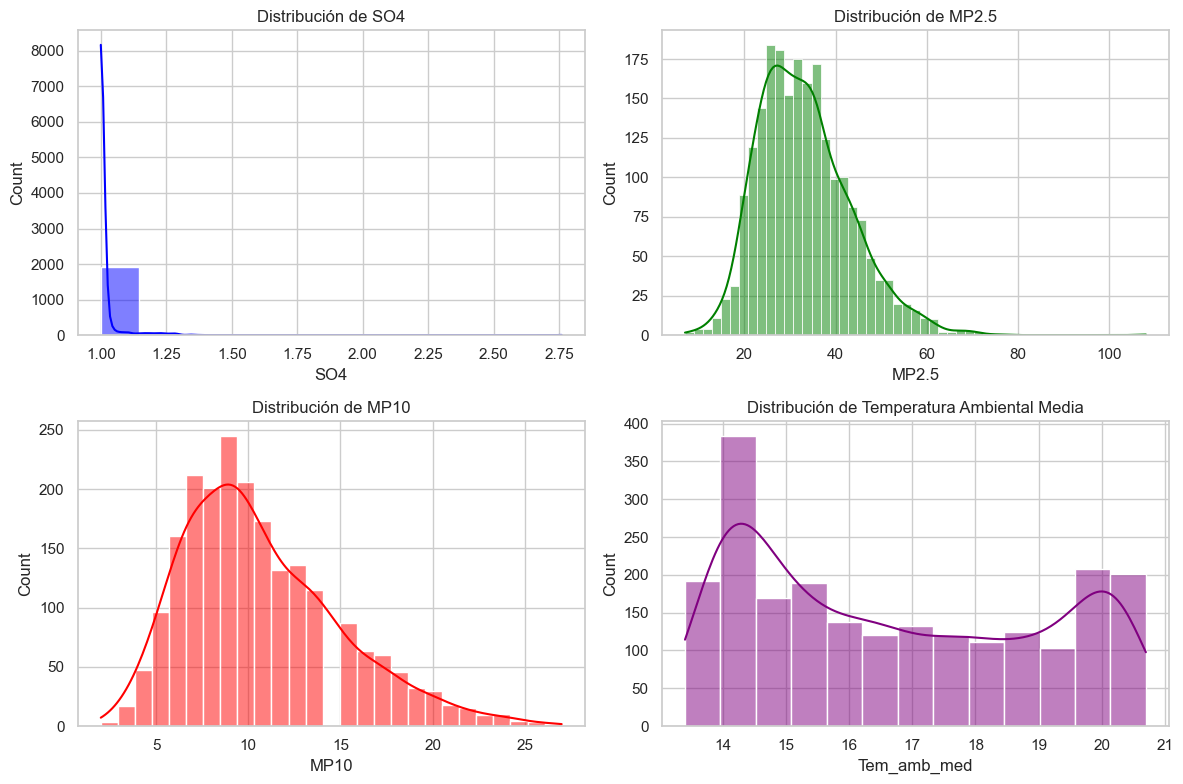

In [212]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear las subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histograma con KDE para SO4
sns.histplot(x=df['SO4'], kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Distribución de SO4')

# Histograma con KDE para MP2.5
sns.histplot(x=df['MP2.5'], kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Distribución de MP2.5')

# Histograma con KDE para MP10
sns.histplot(x=df['MP10'], kde=True, ax=axs[1, 0], color='red')
axs[1, 0].set_title('Distribución de MP10')

# Histograma con KDE para Tem_amb_med
sns.histplot(x=df['Tem_amb_med'], kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Distribución de Temperatura Ambiental Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

<Axes: >

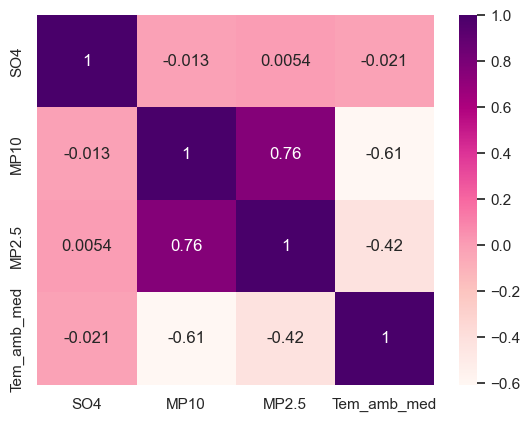

In [213]:
#correlation matrix
df_corr=df.iloc[:,1:].corr()
sns.heatmap(df_corr,cmap='RdPu',annot=True)

#### Imputacion de datos

In [214]:
df["SO4"]=df["SO4"].replace(np.nan,df["SO4"].mode()[0])

In [215]:
# Convertir las variables categóricas a numéricas usando OrdinalEncoder
encoder = OrdinalEncoder()
datos_encoded = df[['MP2.5', 'MP10']].copy()
datos_encoded[['MP2.5', 'MP10']] = encoder.fit_transform(df[['MP2.5', 'MP10']])

In [216]:
datos_encoded.dtypes

MP2.5    float64
MP10     float64
dtype: object

In [217]:
# Aplicar KNNImputer para llenar los valores faltantes
imputador = KNNImputer(n_neighbors=10)
datos_imputados = imputador.fit_transform(datos_encoded)

In [218]:
datos_imputados

array([[17.,  4.],
       [17.,  2.],
       [18.,  4.],
       ...,
       [15.,  5.],
       [12.,  2.],
       [15.,  9.]])

In [219]:
# Convertir los datos imputados de vuelta a un DataFrame
datos_imputados_df = pd.DataFrame(datos_imputados)
datos_imputados_df.columns=['MP2.5', 'MP10']
datos_imputados_df


,MP2.5,MP10
0,17.0,4.0
1,17.0,2.0
2,18.0,4.0
3,15.0,4.0
4,16.0,5.0
...,...,...
2186,16.0,4.0
2187,16.0,5.0
2188,15.0,5.0
2189,12.0,2.0


In [220]:
df=pd.concat([df['date'], df['SO4'], datos_imputados_df,df['Tem_amb_med']], axis=1)

In [221]:
df.describe()

,date,SO4,MP2.5,MP10,Tem_amb_med
count,2191,2191.000000,2191.000000,2191.000000,2191.000000
mean,2020-12-31 00:00:00,1.010561,25.025799,8.700657,16.704153
min,2018-01-01 00:00:00,1.000000,0.000000,0.000000,13.400000
25%,2019-07-02 12:00:00,1.000000,18.000000,6.000000,14.500000
50%,2020-12-31 00:00:00,1.000000,24.000000,8.000000,16.300000
75%,2022-07-01 12:00:00,1.000000,31.000000,11.000000,18.900000
max,2023-12-31 00:00:00,2.760000,64.000000,25.000000,20.700000
std,NaN,0.055794,9.936655,4.275911,2.287611


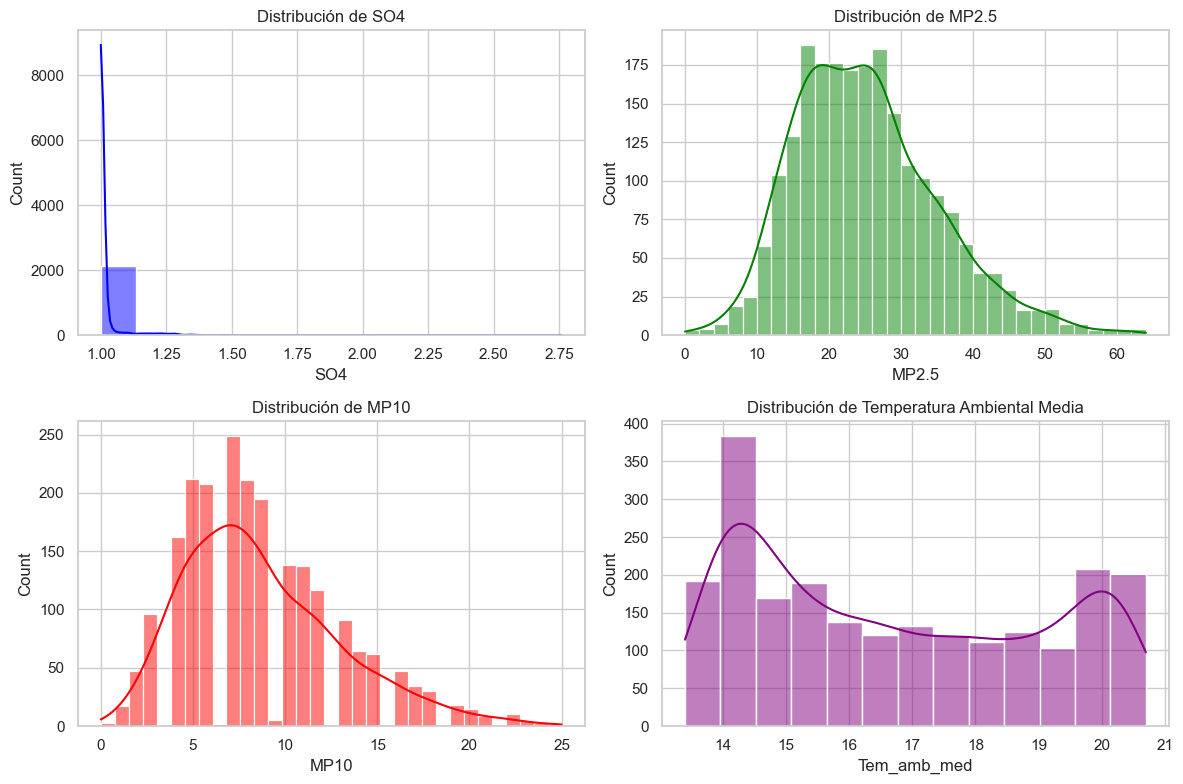

In [222]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear las subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histograma con KDE para SO4
sns.histplot(x=df['SO4'], kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Distribución de SO4')

# Histograma con KDE para MP2.5
sns.histplot(x=df['MP2.5'], kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Distribución de MP2.5')

# Histograma con KDE para MP10
sns.histplot(x=df['MP10'], kde=True, ax=axs[1, 0], color='red')
axs[1, 0].set_title('Distribución de MP10')

# Histograma con KDE para Tem_amb_med
sns.histplot(x=df['Tem_amb_med'], kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Distribución de Temperatura Ambiental Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

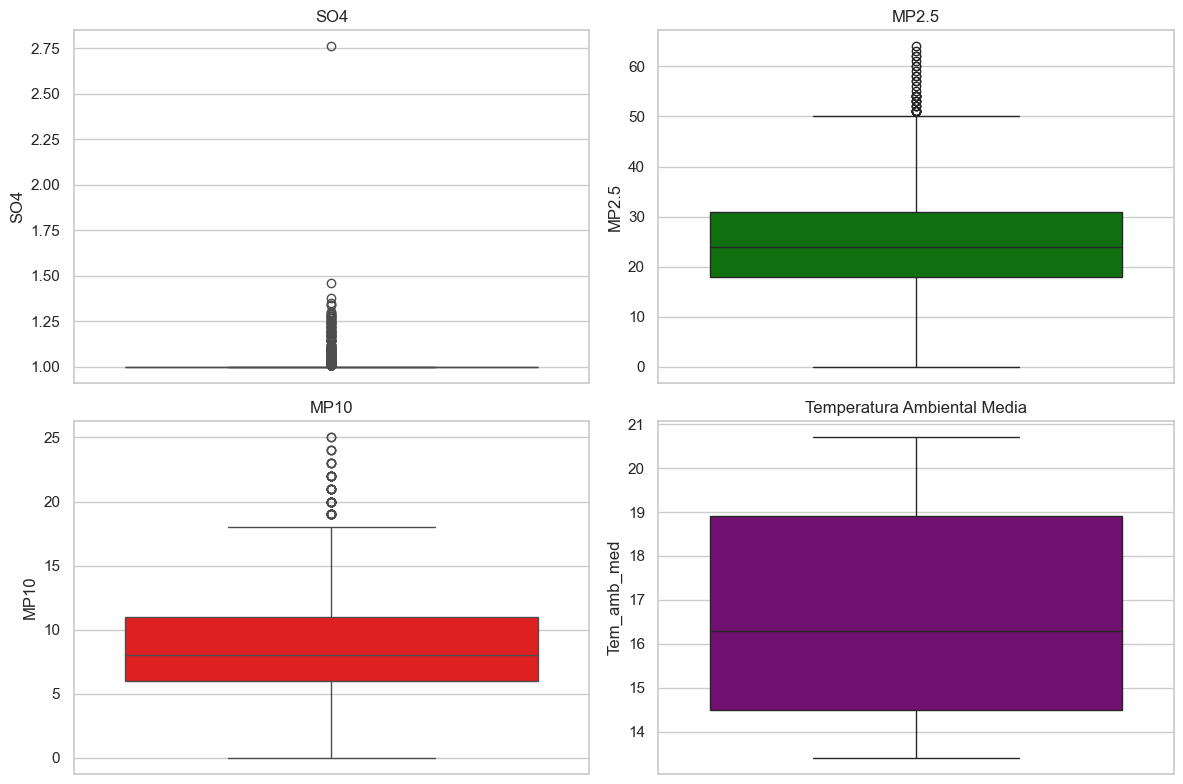

In [223]:
# Estilo de seaborn
sns.set(style="whitegrid")

# Crear las subgráficas 2x2 para los boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot para SO4
sns.boxplot(y=df['SO4'], ax=axs[0, 0], color='blue')
axs[0, 0].set_title('SO4')

# Boxplot para MP2.5
sns.boxplot(y=df['MP2.5'], ax=axs[0, 1], color='green')
axs[0, 1].set_title('MP2.5')

# Boxplot para MP10
sns.boxplot(y=df['MP10'], ax=axs[1, 0], color='red')
axs[1, 0].set_title('MP10')

# Boxplot para Tem_amb_med
sns.boxplot(y=df['Tem_amb_med'], ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Temperatura Ambiental Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

In [224]:
X=df[['date','SO4']]
X2=df[['date','MP2.5']]
X3=df[['date','MP10']]
X4=df[['date','Tem_amb_med']]

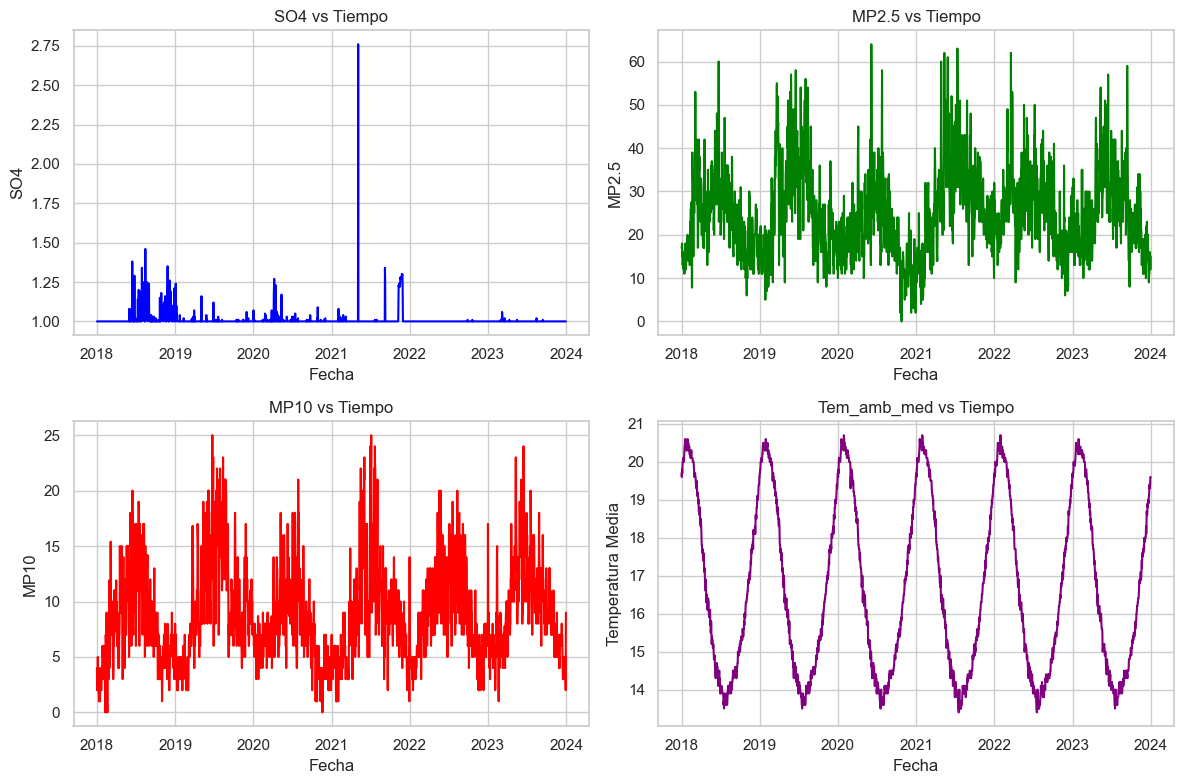

In [225]:
# Crear las subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gráfica para SO4
axs[0, 0].plot(df['date'], df['SO4'], color='blue')
axs[0, 0].set_title('SO4 vs Tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('SO4')

# Gráfica para MP2.5
axs[0, 1].plot(df['date'], df['MP2.5'], color='green')
axs[0, 1].set_title('MP2.5 vs Tiempo')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].set_ylabel('MP2.5')

# Gráfica para MP10
axs[1, 0].plot(df['date'], df['MP10'], color='red')
axs[1, 0].set_title('MP10 vs Tiempo')
axs[1, 0].set_xlabel('Fecha')
axs[1, 0].set_ylabel('MP10')

# Gráfica para Tem_amb_med
axs[1, 1].plot(df['date'], df['Tem_amb_med'], color='purple')
axs[1, 1].set_title('Tem_amb_med vs Tiempo')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].set_ylabel('Temperatura Media')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

<Axes: >

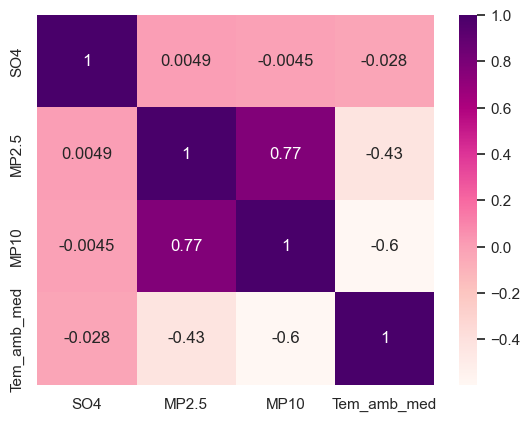

In [226]:
#correlation matrix
df_corr=df.iloc[:,1:].corr()
sns.heatmap(df_corr,cmap='RdPu',annot=True)

In [227]:
df.describe()

,date,SO4,MP2.5,MP10,Tem_amb_med
count,2191,2191.000000,2191.000000,2191.000000,2191.000000
mean,2020-12-31 00:00:00,1.010561,25.025799,8.700657,16.704153
min,2018-01-01 00:00:00,1.000000,0.000000,0.000000,13.400000
25%,2019-07-02 12:00:00,1.000000,18.000000,6.000000,14.500000
50%,2020-12-31 00:00:00,1.000000,24.000000,8.000000,16.300000
75%,2022-07-01 12:00:00,1.000000,31.000000,11.000000,18.900000
max,2023-12-31 00:00:00,2.760000,64.000000,25.000000,20.700000
std,NaN,0.055794,9.936655,4.275911,2.287611


In [228]:
df_save = df.astype(str)
df_save.to_csv('..\output\dataset3.csv', index=False, decimal=',', sep=';')

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\4047311043.py:2: SyntaxWarning: invalid escape sequence '\o'
  df_save.to_csv('..\output\dataset3.csv', index=False, decimal=',', sep=';')


In [229]:
df.to_csv("..\output\dataset.csv", index=False, decimal='.', sep=';')

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\capv2\AppData\Local\Temp\ipykernel_19512\2128806212.py:1: SyntaxWarning: invalid escape sequence '\o'
  df.to_csv("..\output\dataset.csv", index=False, decimal='.', sep=';')


In [230]:
# Separar las características y la variable objetivo
X = df[['SO4', 'MP2.5', 'Tem_amb_med']]  # Características
y = df['MP10']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Coeficiente de Determinación (R²): {r2:.4f}')

Error Cuadrático Medio (MSE): 6.1834
Coeficiente de Determinación (R²): 0.6486


In [231]:
# Separar las características y la variable objetivo
X = df[['SO4', 'MP2.5', 'Tem_amb_med']]  # Características
y = df['MP10']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformar las características para incluir términos polinómicos
degree = 2  # Grado del polinomio
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Crear y entrenar el modelo de regresión polinómica (usando regresión lineal con características polinómicas)
model = LinearRegression()

# Realizar validación cruzada
cv_scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  # Convertir los puntajes negativos a positivos
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Convertir MSE a RMSE

print(f'Scores de validación cruzada (RMSE): {cv_rmse_scores}')
print(f'Promedio de RMSE en validación cruzada: {cv_rmse_scores.mean():.4f}')
print(f'Desviación estándar de RMSE en validación cruzada: {cv_rmse_scores.std():.4f}')

# Ajustar el modelo en los datos de entrenamiento completos
model.fit(X_train_poly, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_poly)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'\nEvaluación en conjunto de prueba:')
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}')
print(f'Coeficiente de Determinación (R²): {r2:.4f}')

Scores de validación cruzada (RMSE): [2.38011429 2.5421412  2.33827131 2.31476189 2.10574625]
Promedio de RMSE en validación cruzada: 2.3362
Desviación estándar de RMSE en validación cruzada: 0.1399

Evaluación en conjunto de prueba:
Error Cuadrático Medio (MSE): 6.1773
Raíz del Error Cuadrático Medio (RMSE): 2.4854
Coeficiente de Determinación (R²): 0.6490


In [232]:
#df_ope=pd.read_csv("..\output\dataset.csv", sep=";")

In [233]:
#df_ope.describe()